In [37]:


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [59]:

#To unzip and read the csv file inside the zip file

import zipfile

with zipfile.ZipFile('/content/BBC News Train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_data')

In [60]:


with open("extracted_data/BBC News Train.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"The second line (first data point) looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

ArticleId,Text,Category

The second line (first data point) looks like this:

1833,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in e

In [40]:

# Define the global variables
VOCAB_SIZE = 1000
EMBEDDING_DIM = 16
MAX_LENGTH = 120
TRAINING_SPLIT = 0.8

In [74]:
data_dir = "/content/bbc-tect.csv"
data = np.loadtxt(data_dir, delimiter=',', skiprows=0, dtype='str', comments=None)
print(f"Shape of the data: {data.shape}")
print(f"{data[0]}\n{data[1]}")

Shape of the data: (2226, 2)
['Category' 'Text']
['Business' 'Sample text for 0']


In [81]:
# Print the first 5 labels from the first column
print(f"The first 5 labels are {data[:5, 0]}")


The first 5 labels are ['Business' 'Sports' 'Politics' 'Technology' 'Entertainment']


In [82]:
# Check the content of the first row
print(f"First row (Category, Text): {data[0]}")

# Print the number of sentence-label pairs
print(f"There are {len(data)} sentence-label pairs in the dataset.\n")

# Check if the first sentence is correctly split into words
print(f"First sentence has {len(data[0, 1].split())} words.\n")

# Print the first 5 labels (from the "category" column)
print(f"The first 5 labels are {data[:5, 0]}")



First row (Category, Text): ['Business' 'Sample text for 0']
There are 2225 sentence-label pairs in the dataset.

First sentence has 4 words.

The first 5 labels are ['Business' 'Sports' 'Politics' 'Technology' 'Entertainment']


In [83]:
import numpy as np

# Reload the CSV file, but skip the first row which contains the headers
data = np.loadtxt("/content/bbc-tect.csv", delimiter=',', skiprows=1, dtype='str', comments=None)

# Now the dataset will not include the header, and you'll work with the actual data
print(f"There are {len(data)} sentence-label pairs in the dataset.\n")

# Check the number of words in the first sentence (now it should be correct)
print(f"First sentence has {len(data[0, 1].split())} words.\n")

# Print the first 5 labels (category column, index 0)
print(f"The first 5 labels are {data[:5, 0]}")


There are 2225 sentence-label pairs in the dataset.

First sentence has 4 words.

The first 5 labels are ['Business' 'Sports' 'Politics' 'Technology' 'Entertainment']


In [84]:
# GRADED FUNCTIONS: train_val_datasets
def train_val_datasets(data,train_split=1780/2225):
    '''
    Splits data into traning and validations sets

    Args:
        data (np.array): array with two columns, first one is the label, the second is the text

    Returns:
        (tf.data.Dataset, tf.data.Dataset): tuple containing the train and validation datasets
    '''
   ### START CODE HERE ###

    # Compute the number of samples that will be used for training
    train_size = int(len(data) * train_split)

    # Slice the dataset to get only the texts and labels
    texts = data[:, 1]  # texts are in the second column
    labels = data[:, 0]  # labels are in the first column

    # Split the texts and labels into train/validation splits
    train_texts = texts[:train_size]
    validation_texts = texts[train_size:]
    train_labels = labels[:train_size]
    validation_labels = labels[train_size:]

    # Create the train and validation datasets from the splits
    train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_texts, validation_labels))

    ### END CODE HERE ###


    return train_dataset, validation_dataset

In [85]:
# Create the datasets
train_dataset, validation_dataset = train_val_datasets(data)
print('Name: Meetha Prabhu       Register Number: 212222240065      ')
print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

Name: Meetha Prabhu       Register Number: 212222240065      
There are 1780 sentence-label pairs for training.

There are 445 sentence-label pairs for validation.



In [86]:
def standardize_func(sentence):
    """
    Removes a list of stopwords

    Args:
        sentence (tf.string): sentence to remove the stopwords from

    Returns:
        sentence (tf.string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "her", "here",  "hers", "herself", "him", "himself", "his", "how",  "i", "if", "in", "into", "is", "it", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she",  "should", "so", "some", "such", "than", "that",  "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we",  "were", "what",  "when", "where", "which", "while", "who", "whom", "why", "why", "with", "would", "you",  "your", "yours", "yourself", "yourselves", "'m",  "'d", "'ll", "'re", "'ve", "'s", "'d"]

    # Sentence converted to lowercase-only
    sentence = tf.strings.lower(sentence)

    # Remove stopwords
    for word in stopwords:
        if word[0] == "'":
            sentence = tf.strings.regex_replace(sentence, rf"{word}\b", "")
        else:
            sentence = tf.strings.regex_replace(sentence, rf"\b{word}\b", "")

    # Remove punctuation
    sentence = tf.strings.regex_replace(sentence, r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', "")


    return sentence


In [87]:
# GRADED FUNCTION: fit_vectorizer
def fit_vectorizer(train_sentences, standardize_func):
    '''
    Defines and adapts the text vectorizer

    Args:
        train_sentences (tf.data.Dataset): sentences from the train dataset to fit the TextVectorization layer
        standardize_func (FunctionType): function to remove stopwords and punctuation, and lowercase texts.
    Returns:
        TextVectorization: adapted instance of TextVectorization layer
    '''
    ### START CODE HERE ###

    # If train_sentences is a NumPy array, convert it to a TensorFlow Dataset
    if isinstance(train_sentences, np.ndarray):
        train_sentences = tf.data.Dataset.from_tensor_slices(train_sentences)

    # Initialize the TextVectorization layer
    vectorizer = tf.keras.layers.TextVectorization(
        standardize=standardize_func,     # Using the custom standardization function
        max_tokens=1000,                  # Set the vocabulary size to 1000
        output_sequence_length=120        # Set the maximum sequence length to 120
    )

    # Adapt the vectorizer to the training sentences
    vectorizer.adapt(train_sentences.map(lambda text: text))  # Adapting only the text from (text, label) pairs

    ### END CODE HERE ###

    return vectorizer

In [88]:

# Create the vectorizer
text_only_dataset = train_dataset.map(lambda text, label: text)
vectorizer = fit_vectorizer(text_only_dataset, standardize_func)
vocab_size = vectorizer.vocabulary_size()
print('Name: Meetha Prabhu       Register Number: 212222240065      ')
print(f"Vocabulary contains {vocab_size} words\n")

Name: Meetha Prabhu       Register Number: 212222240065      
Vocabulary contains 1000 words



In [89]:
# GRADED FUNCTION: fit_label_encoder
def fit_label_encoder(train_labels, validation_labels):
    """Creates an instance of a StringLookup, and trains it on all labels

    Args:
        train_labels (tf.data.Dataset): dataset of train labels
        validation_labels (tf.data.Dataset): dataset of validation labels

    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    ### START CODE HERE ###

    # Join the two label datasets by concatenating them
    labels = train_labels.concatenate(validation_labels)

    # Instantiate the StringLookup layer. We set mask_token=None and num_oov_indices=0 to avoid OOV tokens
    label_encoder = tf.keras.layers.StringLookup(mask_token=None, num_oov_indices=0)

    # Fit the StringLookup layer on the concatenated labels
    label_encoder.adapt(labels)

    ### END CODE HERE ###

    return label_encoder

In [90]:
# Create the label encoder
train_labels_only = train_dataset.map(lambda text, label: label)
validation_labels_only = validation_dataset.map(lambda text, label: label)

label_encoder = fit_label_encoder(train_labels_only,validation_labels_only)
print('Name: Meetha Prabhu       Register Number: 212222240065      ')
print(f'Unique labels: {label_encoder.get_vocabulary()}')

Name: Meetha Prabhu       Register Number: 212222240065      
Unique labels: ['Technology', 'Sports', 'Politics', 'Entertainment', 'Business']


In [91]:
# GRADED FUNCTION: preprocess_dataset
def preprocess_dataset(dataset, text_vectorizer, label_encoder):
    """Apply the preprocessing to a dataset

    Args:
        dataset (tf.data.Dataset): dataset to preprocess
        text_vectorizer (tf.keras.layers.TextVectorization ): text vectorizer
        label_encoder (tf.keras.layers.StringLookup): label encoder

    Returns:
        tf.data.Dataset: transformed dataset
    """

      ### START CODE HERE ###

    # Apply text vectorization and label encoding
    dataset = dataset.map(lambda text, label: (text_vectorizer(text), label_encoder(label)))

    # Set the batch size to 32
    dataset = dataset.batch(32)

    ### END CODE HERE ###

    return dataset

In [92]:

# Preprocess your dataset
train_proc_dataset = preprocess_dataset(train_dataset, vectorizer, label_encoder)
validation_proc_dataset = preprocess_dataset(validation_dataset, vectorizer, label_encoder)

In [93]:

train_batch = next(train_proc_dataset.as_numpy_iterator())
validation_batch = next(validation_proc_dataset.as_numpy_iterator())
print('Name: Meetha Prabhu       Register Number: 212222240065      ')
print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Name: Meetha Prabhu       Register Number: 212222240065      
Shape of the train batch: (32, 120)
Shape of the validation batch: (32, 120)


In [94]:
# GRADED FUNCTION: create_model
def create_model():
    """
    Creates a text classifier model
    Returns:
      tf.keras Model: the text classifier model
    """

      ### START CODE HERE ###

    model = tf.keras.Sequential([
        tf.keras.Input(shape=(120,)),  # Input layer with a fixed sequence length of 120
        tf.keras.layers.Embedding(input_dim=1000, output_dim=16),  # Smaller embedding layer (reduce output_dim)
        tf.keras.layers.GlobalAveragePooling1D(),  # Global average pooling to reduce complexity
        tf.keras.layers.Dense(16, activation='relu'),  # Reduced Dense layer size to 16 units
        tf.keras.layers.Dense(5, activation='softmax')  # Output layer with 5 units for 5 classes
    ])

    # Compile the model with appropriate loss, optimizer, and metrics
    model.compile(
        loss='sparse_categorical_crossentropy',  # Use sparse categorical cross-entropy for integer-encoded labels
        optimizer='adam',  # Adam optimizer
        metrics=['accuracy']  # Track accuracy
    )

    ### END CODE HERE ###

    return model

In [95]:
# Get the untrained model
model = create_model()

In [96]:
example_batch = train_proc_dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 5)


In [97]:
history = model.fit(train_proc_dataset, epochs=30, validation_data=validation_proc_dataset)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.2014 - loss: 1.6096 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2238 - loss: 1.6094 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2817 - loss: 1.6093 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3373 - loss: 1.6091 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3981 - loss: 1.6090 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4236 - loss: 1.6087 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4427 - loss: 1.6084 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5038 - loss: 1.6078 - val_accuracy: 0.2000 - v

Name: Meetha Prabhu       Register Number: 212222240065      


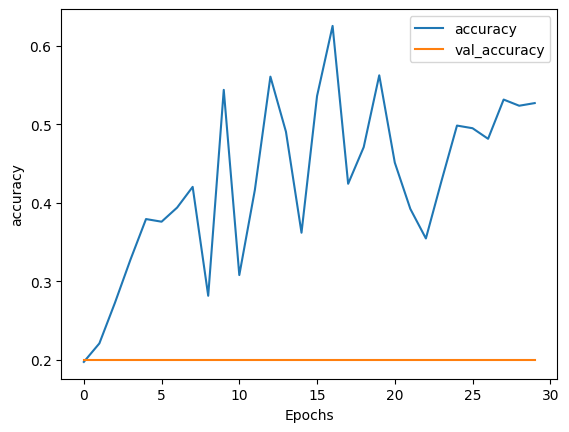

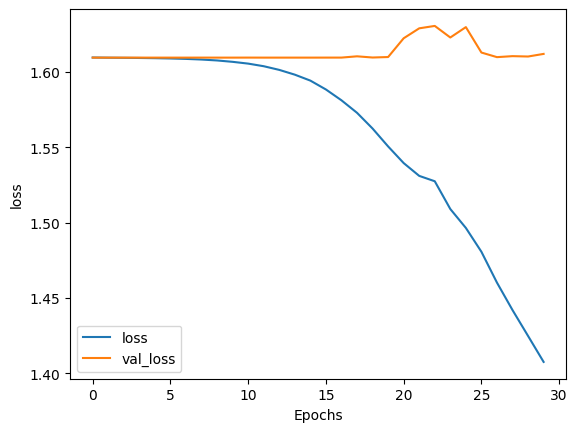

In [98]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
print('Name: Meetha Prabhu       Register Number: 212222240065      ')
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")